# **Data Science Assessment for Andani**

In this notebook, we will conduct an analysis and predictive modeling exercise as part of the Data Science assessment, utilizing the Open University Learning Analytics Dataset (OULAD). This dataset captures student interaction data within a Virtual Learning Environment (VLE).

Our objective is to analyze and identify key patterns in student behavior and performance. Based on these insights, we will develop a predictive model capable of effectively forecasting student performance.

In [1]:
import pandas as pd
import numpy as np
import glob
import os
from matplotlib import pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import roc_curve, confusion_matrix,accuracy_score, roc_auc_score, classification_report
from sklearn.feature_selection import chi2
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
sns.set()


In [2]:
csv_files = glob.glob('oulad_data/*.csv')
dataframes = {os.path.basename(file): pd.read_csv(file) for file in csv_files}

### **1. Data Pre-Processing, Exploration and Feature engineering**

#### **1.2 Data Processing and Exploration**

1.1 In this section, we will load the dataset into a Pandas DataFrame and examine its structure to gain a better understanding of the data. This includes exploring key attributes, identifying missing values, and assessing data types. Furthermore, we will consolidate multiple DataFrames into a single unified dataset, ensuring consistency and completeness. This step is crucial in preparing the data for the exploratory analysis that follows, enabling us to uncover meaningful patterns and insights.

In [3]:
dataframes.keys()

dict_keys(['assessments.csv', 'courses.csv', 'studentAssessment.csv', 'studentInfo.csv', 'studentRegistration.csv', 'studentVle.csv', 'vle.csv'])

In [4]:
for name in list(dataframes.keys()):
    old_name = name
    new_name = name.removesuffix(".csv")
    dataframes.update( {new_name: dataframes.pop(old_name)})

In [5]:
dataframes.keys()

dict_keys(['assessments', 'courses', 'studentAssessment', 'studentInfo', 'studentRegistration', 'studentVle', 'vle'])

The dataset consists of seven different DataFrames, each derived from separate CSV files. These DataFrames contain essential information related to students, courses, assessments, and interactions within the Virtual Learning Environment (VLE).

In [6]:
def print_dict_shapes(dataframes):
    for name, df in dataframes.items():
        rows, cols = df.shape
        print(f"'{name}' DataFrame: {rows} rows, {cols} columns")

print_dict_shapes(dataframes)

'assessments' DataFrame: 40 rows, 6 columns
'courses' DataFrame: 10 rows, 3 columns
'studentAssessment' DataFrame: 5392 rows, 5 columns
'studentInfo' DataFrame: 1507 rows, 12 columns
'studentRegistration' DataFrame: 1507 rows, 5 columns
'studentVle' DataFrame: 114130 rows, 6 columns
'vle' DataFrame: 200 rows, 6 columns


In [7]:
dataframes['assessments'].head(10)

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1,TMA,30,20
1,AAA,2013J,2,TMA,75,20
2,AAA,2013J,3,TMA,120,20
3,AAA,2013J,4,Exam,230,100
4,AAA,2014B,5,TMA,30,20
5,AAA,2014B,6,CMA,75,30
6,AAA,2014B,7,TMA,120,20
7,AAA,2014B,8,Exam,230,100
8,BBB,2013J,9,CMA,30,30
9,BBB,2013J,10,CMA,75,30


In [8]:
dataframes['courses'].head()

,code_module,code_presentation,length
0,AAA,2013J,240
1,AAA,2014B,240
2,BBB,2013J,240
3,BBB,2014B,240
4,CCC,2013J,240


In [9]:
dataframes['studentAssessment'].head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1,9,26,0,29
1,1,10,28,0,55
2,1,12,29,0,76
3,1,16,27,0,24
4,1,19,24,0,19


In [10]:
print(f'the dataframe has {dataframes['studentAssessment'].shape[0]} rows and {dataframes['studentAssessment'].shape[1]} columns')

the dataframe has 5392 rows and 5 columns


In [11]:
dataframes['studentInfo'].head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,BBB,2014B,1,M,Wales,A Level or Equivalent,20-30%,55<=,2,90,N,Fail
1,EEE,2014B,2,F,North Region,A Level or Equivalent,40-50%,0-35,1,150,N,Pass
2,DDD,2013J,2,M,South East Region,Post Graduate Qualification,20-30%,55<=,0,90,N,Fail
3,CCC,2014B,3,F,South East Region,HE Qualification,90-100%,0-35,1,120,N,Fail
4,BBB,2014B,4,M,South Region,A Level or Equivalent,70-80%,35-55,1,60,N,Distinction


In [12]:
dataframes['studentInfo'].id_student.nunique()

1000

In [13]:
dataframes['studentRegistration'].head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,BBB,2014B,1,-51,NaN
1,EEE,2014B,2,-40,NaN
2,DDD,2013J,2,-56,NaN
3,CCC,2014B,3,-50,NaN
4,BBB,2014B,4,-39,NaN


In [14]:
dataframes['studentVle'].head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,BBB,2014B,1,68,57,1
1,BBB,2014B,1,63,73,3
2,BBB,2014B,1,67,176,3
3,BBB,2014B,1,76,53,9
4,BBB,2014B,1,79,193,4


In [15]:
dataframes['studentVle'].id_student.nunique()

1000

In [16]:
dataframes['vle'].head(10)

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,1,AAA,2013J,quiz,4,12
1,2,AAA,2013J,subpage,25,32
2,3,AAA,2013J,page,4,7
3,4,AAA,2013J,glossary,7,11
4,5,AAA,2013J,oucontent,20,21
5,6,AAA,2013J,glossary,27,34
6,7,AAA,2013J,resource,26,30
7,8,AAA,2013J,forum,3,6
8,9,AAA,2013J,quiz,1,5
9,10,AAA,2013J,subpage,1,9


Since this dataframe contains week from and week to we use those columns or values to derive a new column called number of week which will be the number of weeks spent on the site in the Virtual learning environment additionally we will have 1 as a count of the activity on the VLE

In [17]:
dataframes['vle']['number_of_weeks_on_vle'] = dataframes['vle'].week_to - dataframes['vle'].week_from
dataframes['vle']['activity_count'] = 1
dataframes['vle'].head(10)

,id_site,code_module,code_presentation,activity_type,week_from,week_to,number_of_weeks_on_vle,activity_count
0,1,AAA,2013J,quiz,4,12,8,1
1,2,AAA,2013J,subpage,25,32,7,1
2,3,AAA,2013J,page,4,7,3,1
3,4,AAA,2013J,glossary,7,11,4,1
4,5,AAA,2013J,oucontent,20,21,1,1
5,6,AAA,2013J,glossary,27,34,7,1
6,7,AAA,2013J,resource,26,30,4,1
7,8,AAA,2013J,forum,3,6,3,1
8,9,AAA,2013J,quiz,1,5,4,1
9,10,AAA,2013J,subpage,1,9,8,1


Notice from the above that the StudentVLE dataset contains the most number of records which track the activities of each student on the VLE, we will aggregate the values so that we get an activity for each student, module and presentation code, this will allow us to consolidate the data without creating duplicate records

In [18]:
df_studentVle = dataframes['studentVle'].groupby(['id_site','code_module','code_presentation','id_student'],sort=False)['sum_click'].sum().reset_index()

In [19]:
df_studentVle

,id_site,code_module,code_presentation,id_student,sum_click
0,68,BBB,2014B,1,13
1,63,BBB,2014B,1,17
2,67,BBB,2014B,1,36
3,76,BBB,2014B,1,34
4,79,BBB,2014B,1,11
...,...,...,...,...,...
27092,26,AAA,2014B,1000,21
27093,38,AAA,2014B,1000,19
27094,28,AAA,2014B,1000,32
27095,24,AAA,2014B,1000,16


In [20]:
print(df_studentVle.id_student.nunique())
dataframes['studentVle'].id_site.nunique()

1000


200

In [21]:
df_studentVle[df_studentVle.id_student==100]

,id_site,code_module,code_presentation,id_student,sum_click
2557,79,BBB,2014B,100,36
2558,61,BBB,2014B,100,60
2559,71,BBB,2014B,100,28
2560,62,BBB,2014B,100,40
2561,76,BBB,2014B,100,42
2562,70,BBB,2014B,100,34
2563,72,BBB,2014B,100,38
2564,65,BBB,2014B,100,22
2565,77,BBB,2014B,100,45
2566,63,BBB,2014B,100,19


In the following cell, we combine the VLE and StudentVLE datasets to aggregate the data.

In [22]:
vle_df = df_studentVle.merge(dataframes['vle'], on = ['id_site','code_module','code_presentation'],how = 'left')

In [23]:
vle_df

,id_site,code_module,code_presentation,id_student,sum_click,activity_type,week_from,week_to,number_of_weeks_on_vle,activity_count
0,68,BBB,2014B,1,13,url,23,24,1,1
1,63,BBB,2014B,1,17,url,26,31,5,1
2,67,BBB,2014B,1,36,forum,8,14,6,1
3,76,BBB,2014B,1,34,oucontent,4,11,7,1
4,79,BBB,2014B,1,11,page,26,28,2,1
...,...,...,...,...,...,...,...,...,...,...
27092,26,AAA,2014B,1000,21,glossary,27,32,5,1
27093,38,AAA,2014B,1000,19,page,26,35,9,1
27094,28,AAA,2014B,1000,32,url,22,31,9,1
27095,24,AAA,2014B,1000,16,url,26,27,1,1


In [24]:
vle_df = vle_df.groupby(['code_module','code_presentation','id_student'],sort=False)[['sum_click','number_of_weeks_on_vle','activity_count']].sum().reset_index()
vle_df

,code_module,code_presentation,id_student,sum_click,number_of_weeks_on_vle,activity_count
0,BBB,2014B,1,375,96,20
1,EEE,2014B,2,201,74,15
2,DDD,2013J,2,52,59,9
3,CCC,2014B,3,245,91,19
4,BBB,2014B,4,780,94,19
...,...,...,...,...,...,...
1502,EEE,2013J,998,446,102,20
1503,BBB,2014B,998,461,96,20
1504,AAA,2014B,999,155,83,15
1505,EEE,2014B,999,244,80,17


  #### **1.2 Consolidating the Datasets**

In this section we combine all the provisioned datasets in order to get a combined view which will allow us to extract deeper insights into student interactions with the Virtual Learning Environment.

In [25]:
df_1 = dataframes['assessments'].merge(dataframes['courses'],on = ['code_module','code_presentation'] ,how = 'left')
df_1.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,length
0,AAA,2013J,1,TMA,30,20,240
1,AAA,2013J,2,TMA,75,20,240
2,AAA,2013J,3,TMA,120,20,240
3,AAA,2013J,4,Exam,230,100,240
4,AAA,2014B,5,TMA,30,20,240


In [26]:
df_1.shape

(40, 7)

In [27]:
df_1 = df_1.merge(dataframes['studentAssessment'],on = ['id_assessment'] ,how = 'left')
df_1.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,length,id_student,date_submitted,is_banked,score
0,AAA,2013J,1,TMA,30,20,240,9,26,0,29
1,AAA,2013J,1,TMA,30,20,240,10,28,0,55
2,AAA,2013J,1,TMA,30,20,240,12,29,0,76
3,AAA,2013J,1,TMA,30,20,240,16,27,0,24
4,AAA,2013J,1,TMA,30,20,240,19,24,0,19


In [28]:
#df_1[df_1.id_student == 1]
np.max(df_1[df_1.assessment_type == 'Exam']['score'])
df_1['weighted_score'] = (df_1['score']/100) * df_1['weight']
df_1.head(10)

,code_module,code_presentation,id_assessment,assessment_type,date,weight,length,id_student,date_submitted,is_banked,score,weighted_score
0,AAA,2013J,1,TMA,30,20,240,9,26,0,29,5.8
1,AAA,2013J,1,TMA,30,20,240,10,28,0,55,11.0
2,AAA,2013J,1,TMA,30,20,240,12,29,0,76,15.2
3,AAA,2013J,1,TMA,30,20,240,16,27,0,24,4.8
4,AAA,2013J,1,TMA,30,20,240,19,24,0,19,3.8
5,AAA,2013J,1,TMA,30,20,240,24,29,0,29,5.8
6,AAA,2013J,1,TMA,30,20,240,29,29,0,58,11.6
7,AAA,2013J,1,TMA,30,20,240,30,27,0,73,14.6
8,AAA,2013J,1,TMA,30,20,240,43,25,0,83,16.6
9,AAA,2013J,1,TMA,30,20,240,49,30,0,84,16.8


In [29]:
cols = ['code_module', 'code_presentation', 'assessment_type','length','id_student','is_banked']

df = df_1.groupby(cols,as_index=False)[['weighted_score','weight']].sum()

In [30]:
df[df['id_student']==1]

,code_module,code_presentation,assessment_type,length,id_student,is_banked,weighted_score,weight
1045,BBB,2014B,CMA,240,1,0,12.6,60
1208,BBB,2014B,Exam,240,1,0,18.0,100
1362,BBB,2014B,TMA,240,1,0,10.2,20


In [31]:
cols = ['code_module', 'code_presentation','length','id_student','is_banked']
df = df_1.groupby(cols,as_index=False)[['weighted_score','weight']].sum()

In [32]:
df

,code_module,code_presentation,length,id_student,is_banked,weighted_score,weight
0,AAA,2013J,240,9,0,63.4,160
1,AAA,2013J,240,10,0,92.8,160
2,AAA,2013J,240,12,0,121.2,160
3,AAA,2013J,240,16,0,77.6,160
4,AAA,2013J,240,19,0,33.4,160
...,...,...,...,...,...,...,...
1424,EEE,2014B,240,955,0,40.8,160
1425,EEE,2014B,240,980,0,145.4,160
1426,EEE,2014B,240,985,0,141.0,160
1427,EEE,2014B,240,986,0,24.8,160


In [33]:
df.shape

(1429, 7)

In [34]:
df_1 = df.merge(dataframes['studentInfo'],on = ['code_module','code_presentation','id_student'] ,how = 'left')
df_1.head()

,code_module,code_presentation,length,id_student,is_banked,weighted_score,weight,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,240,9,0,63.4,160,F,South East Region,Post Graduate Qualification,80-90%,55<=,1,30,N,Fail
1,AAA,2013J,240,10,0,92.8,160,F,North Western Region,HE Qualification,40-50%,0-35,0,90,N,Pass
2,AAA,2013J,240,12,0,121.2,160,M,South Region,Post Graduate Qualification,30-40%,55<=,1,90,N,Pass
3,AAA,2013J,240,16,0,77.6,160,F,Wales,HE Qualification,0-10%,0-35,0,90,N,Fail
4,AAA,2013J,240,19,0,33.4,160,F,East Midlands Region,No Formal quals,90-100%,55<=,0,120,N,Fail


In [35]:
df_1['final_score%'] = df_1['weighted_score']/  df_1['weight'] *100

In [36]:
df_1[df_1['id_student']==980]

,code_module,code_presentation,length,id_student,is_banked,weighted_score,weight,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,final_score%
1425,EEE,2014B,240,980,0,145.4,160,M,East Anglian Region,Lower Than A Level,80-90%,35-55,0,90,N,Distinction,90.875


In [37]:
df_1.shape

(1429, 17)

In [38]:
df_1 = df_1.merge(dataframes['studentRegistration'],on = ['code_module','code_presentation','id_student'] ,how = 'left')
df_1.head()

,code_module,code_presentation,length,id_student,is_banked,weighted_score,weight,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,final_score%,date_registration,date_unregistration
0,AAA,2013J,240,9,0,63.4,160,F,South East Region,Post Graduate Qualification,80-90%,55<=,1,30,N,Fail,39.625,-15,NaN
1,AAA,2013J,240,10,0,92.8,160,F,North Western Region,HE Qualification,40-50%,0-35,0,90,N,Pass,58.000,-25,NaN
2,AAA,2013J,240,12,0,121.2,160,M,South Region,Post Graduate Qualification,30-40%,55<=,1,90,N,Pass,75.750,-38,NaN
3,AAA,2013J,240,16,0,77.6,160,F,Wales,HE Qualification,0-10%,0-35,0,90,N,Fail,48.500,-41,NaN
4,AAA,2013J,240,19,0,33.4,160,F,East Midlands Region,No Formal quals,90-100%,55<=,0,120,N,Fail,20.875,-27,NaN


In [39]:
df_1.shape

(1429, 19)

In [40]:
df_studentVle.head()

,id_site,code_module,code_presentation,id_student,sum_click
0,68,BBB,2014B,1,13
1,63,BBB,2014B,1,17
2,67,BBB,2014B,1,36
3,76,BBB,2014B,1,34
4,79,BBB,2014B,1,11


In [41]:
cols = ['code_module', 'code_presentation','length','id_student','is_banked']
df = df_1.groupby(cols,as_index=False)[['weighted_score','weight']].sum()

In [42]:
df_1 = df_1.merge(vle_df,on = ['code_module','code_presentation','id_student'] ,how = 'left')
df_1.head(15)

,code_module,code_presentation,length,id_student,is_banked,weighted_score,weight,gender,region,highest_education,...,num_of_prev_attempts,studied_credits,disability,final_result,final_score%,date_registration,date_unregistration,sum_click,number_of_weeks_on_vle,activity_count
0,AAA,2013J,240,9,0,63.4,160,F,South East Region,Post Graduate Qualification,...,1,30,N,Fail,39.625,-15,NaN,148,72,14
1,AAA,2013J,240,10,0,92.8,160,F,North Western Region,HE Qualification,...,0,90,N,Pass,58.000,-25,NaN,448,97,20
2,AAA,2013J,240,12,0,121.2,160,M,South Region,Post Graduate Qualification,...,1,90,N,Pass,75.750,-38,NaN,335,97,20
3,AAA,2013J,240,16,0,77.6,160,F,Wales,HE Qualification,...,0,90,N,Fail,48.500,-41,NaN,108,84,18
4,AAA,2013J,240,19,0,33.4,160,F,East Midlands Region,No Formal quals,...,0,120,N,Fail,20.875,-27,NaN,417,97,20
5,AAA,2013J,240,24,0,62.4,160,F,London Region,Post Graduate Qualification,...,2,120,N,Fail,39.000,-45,NaN,191,79,17
6,AAA,2013J,240,29,0,21.6,40,M,Wales,A Level or Equivalent,...,1,60,N,Withdrawn,54.000,-13,148.0,149,66,14
7,AAA,2013J,240,30,0,126.2,160,F,South East Region,Post Graduate Qualification,...,1,150,N,Pass,78.875,-54,NaN,521,97,20
8,AAA,2013J,240,43,0,139.6,160,F,North Western Region,Lower Than A Level,...,1,120,N,Distinction,87.250,-40,NaN,368,97,20
9,AAA,2013J,240,49,0,107.6,160,F,North Region,HE Qualification,...,2,30,N,Pass,67.250,-43,NaN,585,97,20


In [43]:
df_1.shape

(1429, 22)

The new consolidated dataset has 22 columns and 1429 rows which is manageable and contains no duplicates

In [44]:
df_1.shape

(1429, 22)

In [45]:
df_1.columns

Index(['code_module', 'code_presentation', 'length', 'id_student', 'is_banked',
       'weighted_score', 'weight', 'gender', 'region', 'highest_education',
       'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits',
       'disability', 'final_result', 'final_score%', 'date_registration',
       'date_unregistration', 'sum_click', 'number_of_weeks_on_vle',
       'activity_count'],
      dtype='object')

  #### **1.3 Handling Data anomalies**

We will now check for the null values and inconsitancies in the dataset

In [46]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1429 entries, 0 to 1428
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   code_module             1429 non-null   object 
 1   code_presentation       1429 non-null   object 
 2   length                  1429 non-null   int64  
 3   id_student              1429 non-null   int64  
 4   is_banked               1429 non-null   int64  
 5   weighted_score          1429 non-null   float64
 6   weight                  1429 non-null   int64  
 7   gender                  1429 non-null   object 
 8   region                  1429 non-null   object 
 9   highest_education       1429 non-null   object 
 10  imd_band                1429 non-null   object 
 11  age_band                1429 non-null   object 
 12  num_of_prev_attempts    1429 non-null   int64  
 13  studied_credits         1429 non-null   int64  
 14  disability              1429 non-null   

There is only a single column, "date_unregistration," that contains null values. This is expected since most students should be currently enrolled. However, students whose "final_result" is marked as "Withdrawn" should have corresponding deregistration dates, while the rest should have null values.

To simplify this data and improve clarity, we will drop the date_unregistration since we already have withdrawn status however we will check for consistancy between the two columns fist

- If all the students who are withdrawn have unregistation dates

- If all the students who have registration dates are withdrawn

In [47]:
withdrawn_with_null_dates = df_1[(df_1['final_result'] == 'Withdrawn') & (df_1['date_unregistration'].isnull())]
registered_with_dates = df_1[(df_1['final_result'] != 'Withdrawn') & (df_1['date_unregistration'].notnull())]
if not withdrawn_with_null_dates.empty:
    print("Inconsistency found: Some students marked as 'Withdrawn' have no deregistration date.")
    
if not registered_with_dates.empty:
    print("Inconsistency found: Some students who are not 'Withdrawn' have deregistration dates.")

if withdrawn_with_null_dates.empty and registered_with_dates.empty:
    df_1.drop(columns=['date_unregistration'], inplace=True)
    print("No inconsistencies found. 'date_unregistration' column dropped.")

No inconsistencies found. 'date_unregistration' column dropped.


In [48]:
df_1[(df_1['final_score%'] > 80)].final_result.unique()

array(['Distinction', 'Pass'], dtype=object)

In [49]:
df_1[(df_1['final_score%'] > 80)].imd_band.unique()             

array(['40-50%', '10-20%', '50-60%', '70-80%', '0-10%', '20-30%',
       '80-90%', '60-70%', '30-40%', '90-100%'], dtype=object)

Notice that there are students with final mark above 80 but the students are marked as pass instead of distinction, we will rectify that by marking the final result for all students with pass mark 80 and above as "Distinction"

In [50]:
ditinction = df_1[(df_1['final_score%'] > 80) & (df_1['final_result'] == 'Pass') ]
ditinction

,code_module,code_presentation,length,id_student,is_banked,weighted_score,weight,gender,region,highest_education,...,age_band,num_of_prev_attempts,studied_credits,disability,final_result,final_score%,date_registration,sum_click,number_of_weeks_on_vle,activity_count
64,AAA,2013J,240,442,0,128.6,160,F,London Region,A Level or Equivalent,...,0-35,1,120,N,Pass,80.375000,-44,726,97,20
83,AAA,2013J,240,557,0,130.2,160,M,North Region,HE Qualification,...,35-55,0,150,N,Pass,81.375000,-25,483,97,20
110,AAA,2013J,240,802,0,130.8,160,M,East Midlands Region,No Formal quals,...,0-35,0,60,Y,Pass,81.750000,-25,634,97,20
198,AAA,2014B,240,544,0,136.2,170,M,East Midlands Region,A Level or Equivalent,...,0-35,0,30,N,Pass,80.117647,-15,482,100,20
313,BBB,2013J,240,312,0,144.2,180,F,Wales,Lower Than A Level,...,35-55,1,150,Y,Pass,80.111111,-57,577,103,20
524,BBB,2014B,240,680,0,145.6,180,M,London Region,Post Graduate Qualification,...,0-35,1,60,N,Pass,80.888889,-14,603,96,20
637,CCC,2013J,240,386,0,138.0,170,F,East Midlands Region,Lower Than A Level,...,55<=,2,60,Y,Pass,81.176471,-13,428,74,20
1068,DDD,2014B,240,381,0,139.7,170,M,West Midlands Region,Lower Than A Level,...,55<=,0,30,N,Pass,82.176471,-56,279,89,19
1089,DDD,2014B,240,561,0,136.6,170,F,South West Region,No Formal quals,...,0-35,2,90,N,Pass,80.352941,-13,546,93,20
1094,DDD,2014B,240,596,0,136.2,170,F,South Region,Lower Than A Level,...,35-55,0,30,N,Pass,80.117647,-30,603,93,20


In [51]:
df_1.loc[(df_1['final_score%'] >= 80) & (df_1['final_result'] == 'Pass'), 'final_result'] = 'Distinction'


In [52]:
df_1[(df_1['final_score%'] > 80) & (df_1['final_result'] == 'Pass') ]

,code_module,code_presentation,length,id_student,is_banked,weighted_score,weight,gender,region,highest_education,...,age_band,num_of_prev_attempts,studied_credits,disability,final_result,final_score%,date_registration,sum_click,number_of_weeks_on_vle,activity_count


In [53]:
df_1.drop(['length', 'id_student','weight','is_banked'],axis=1, inplace=True)

## **2. Exploratory Data Analysis**

In this section, we will perform Exploratory Data Analysis (EDA) to gain insights into the dataset. This analysis will help us understand the distribution of the data, identify patterns, and explore relationships between different variables

### **2.1 Descriptive Statistics**

In [54]:
df_1.describe()

,weighted_score,num_of_prev_attempts,studied_credits,final_score%,date_registration,sum_click,number_of_weeks_on_vle,activity_count
count,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000
mean,94.559132,0.997901,89.937019,57.306210,-34.178446,392.447866,88.595521,18.189643
std,47.220268,0.805702,42.715054,24.473057,14.600840,221.784814,16.888542,2.994814
min,0.000000,0.000000,30.000000,0.000000,-59.000000,20.000000,12.000000,4.000000
25%,50.600000,0.000000,60.000000,34.555556,-47.000000,216.000000,79.000000,18.000000
50%,113.200000,1.000000,90.000000,66.000000,-34.000000,363.000000,94.000000,20.000000
75%,129.200000,2.000000,120.000000,74.888889,-21.000000,527.000000,98.000000,20.000000
max,178.300000,2.000000,150.000000,99.055556,-10.000000,1091.000000,115.000000,20.000000


1. **Weighted Score**:
   - Mean: 94.56, Median: 113.2 - Right-skewed (mean < median).
   - Std Dev: 47.22 - High variation in scores.
   - Min: 0, Max: 178.3 - Some students have very low scores, indicating possible failures or disengagement.
   - The average is **94.6**, but scores range widely from **0.0** to **178.3**, which indicate a diverse student population with varying abilities or commitment levels.

2. **Number of Previous Attempts**:
   - The majority of students appear to have made **0 or 1 attempt**, with **2 attempts** being the upper limit.
   - The low standard deviation suggests that most students do not exceed multiple retries, possibly due to academic policies or effective preparation.
   - This is not a continuous variable

3. **Studied Credits**:
   - The average number of credits studied is around **89.9**, with the median at **90**, suggesting a fairly balanced workload among students.
   - The wide range from **30 to 150 credits** could indicate differences in program intensity or student choices.

4. **Final Score (%)**:
   - Mean: 57.3, Median: 66 - Slightly negatively-skewed (median > mean).
   - The average final score is **57.3%**, but the high standard deviation (**24.47%**) suggests significant variability in student performance.
   - Some students achieved close to **99%,** while others scored very low, hinting at differences in effort, understanding, or external factors.

5. **Date of Registration**:
   - Not a numerical variable

6. **Sum of Clicks**:
   - Mean: 392.45, Median: 363 - Right-skewed (mean > median).
   - This likely reflects engagement with an online learning platform. The average is **392 clicks**, with a broad range from **20 to 1091*,some students are far more active than others.
   - Std Dev: 221.78 - Some students engage significantly more than others.

7. **Number of Weeks on VLE (Virtual Learning Environment)**:
   - Students spend an average of **88.6 weeks** on the platform, with minimal variation beyond this (standard deviation of **16.88**).
   - The range from **12 to 115 weeks** suggests that some are relatively new users, while others are long-term participants.

8. **Activity Count**:
   - This metric is tightly clustered, with **75%** of students recording **20 activities or fewer**. The average count is **18.19**.
   - Mean: 18.18, Median: 20 negatively-skewed (median > mean).
   = Min: 4, Max: 20 which implies that some students have very low engagement levels.
   - Students with higher activity counts might be more engaged or enrolled in more demanding courses.

In [55]:
df_1.dtypes

code_module                object
code_presentation          object
weighted_score            float64
gender                     object
region                     object
highest_education          object
imd_band                   object
age_band                   object
num_of_prev_attempts        int64
studied_credits             int64
disability                 object
final_result               object
final_score%              float64
date_registration           int64
sum_click                   int64
number_of_weeks_on_vle      int64
activity_count              int64
dtype: object

In [56]:
df_categorical = df_1.select_dtypes(include=object)
len(df_categorical.columns)

9

In [57]:
df_numerical = df_1.select_dtypes(exclude=object)
len(df_numerical.columns)

8

In [58]:
for col in df_categorical.columns:
    unique = df_categorical[col].unique()
    unique.sort()
    print(f'- {col}: has {len(unique)} unique values \n  {unique}')

- code_module: has 5 unique values 
  ['AAA' 'BBB' 'CCC' 'DDD' 'EEE']
- code_presentation: has 2 unique values 
  ['2013J' '2014B']
- gender: has 2 unique values 
  ['F' 'M']
- region: has 11 unique values 
  ['East Anglian Region' 'East Midlands Region' 'London Region'
 'North Region' 'North Western Region' 'Scotland' 'South East Region'
 'South Region' 'South West Region' 'Wales' 'West Midlands Region']
- highest_education: has 5 unique values 
  ['A Level or Equivalent' 'HE Qualification' 'Lower Than A Level'
 'No Formal quals' 'Post Graduate Qualification']
- imd_band: has 10 unique values 
  ['0-10%' '10-20%' '20-30%' '30-40%' '40-50%' '50-60%' '60-70%' '70-80%'
 '80-90%' '90-100%']
- age_band: has 3 unique values 
  ['0-35' '35-55' '55<=']
- disability: has 2 unique values 
  ['N' 'Y']
- final_result: has 4 unique values 
  ['Distinction' 'Fail' 'Pass' 'Withdrawn']


In [59]:
def categorize_region(region):
    if region in ['North Region', 'North Western Region', 'Scotland']:
        return 'North'
    elif region in ['East Midlands Region', 'West Midlands Region']:
        return 'Midlands'
    elif region in ['South Region', 'South West Region']:
        return 'South'
    elif region in ['South East Region', 'London Region']:
        return 'South East & London'
    elif region in ['East Anglian Region', 'Wales']:
        return 'East & Wales'
    else:
        return 'Unknown'

df_1['Area'] = df_1['region'].apply(categorize_region)
df_1[['Area','region']]

,Area,region
0,South East & London,South East Region
1,North,North Western Region
2,South,South Region
3,East & Wales,Wales
4,Midlands,East Midlands Region
...,...,...
1424,South East & London,South East Region
1425,East & Wales,East Anglian Region
1426,East & Wales,East Anglian Region
1427,Midlands,East Midlands Region


In [60]:
def categorize_band(percentage):
    if percentage in ['0-10%', '10-20%']:
        return 'Very Low'
    elif percentage in ['20-30%', '30-40%']:
        return 'Low'
    elif percentage in ['40-50%', '50-60%']:
        return 'Medium'
    elif percentage in ['60-70%', '70-80%']:
        return 'High'
    elif percentage in ['80-90%', '90-100%']:
        return 'Very High'
    else:
        return 'Unknown'

# Apply the function
df_1['IMD_band_range'] = df_1['imd_band'].apply(categorize_band)
df_1[['imd_band','IMD_band_range']]

,imd_band,IMD_band_range
0,80-90%,Very High
1,40-50%,Medium
2,30-40%,Low
3,0-10%,Very Low
4,90-100%,Very High
...,...,...
1424,60-70%,High
1425,80-90%,Very High
1426,30-40%,Low
1427,90-100%,Very High


In [61]:
def categorize_qualification(qual):
    if qual == 'No Formal quals':
        return 'None'
    elif qual == 'Lower Than A Level':
        return 'Lower Than A'
    elif qual == 'A Level or Equivalent':
        return 'Mid or A-level'
    elif qual == 'HE Qualification':
        return 'Higher'
    elif qual == 'Post Graduate Qualification':
        return 'Postgrad'
    else:
        return 'Unknown'

# Apply the function
df_1['Qualification'] = df_1['highest_education'].apply(categorize_qualification)

In [62]:
df_1.drop(['region','imd_band','highest_education'], axis=1, inplace=True)

### **2.2 Data Visualisation**

In [63]:
df_categorical = df_1.select_dtypes(include=object)
df_numerical = df_1.select_dtypes(exclude=object)

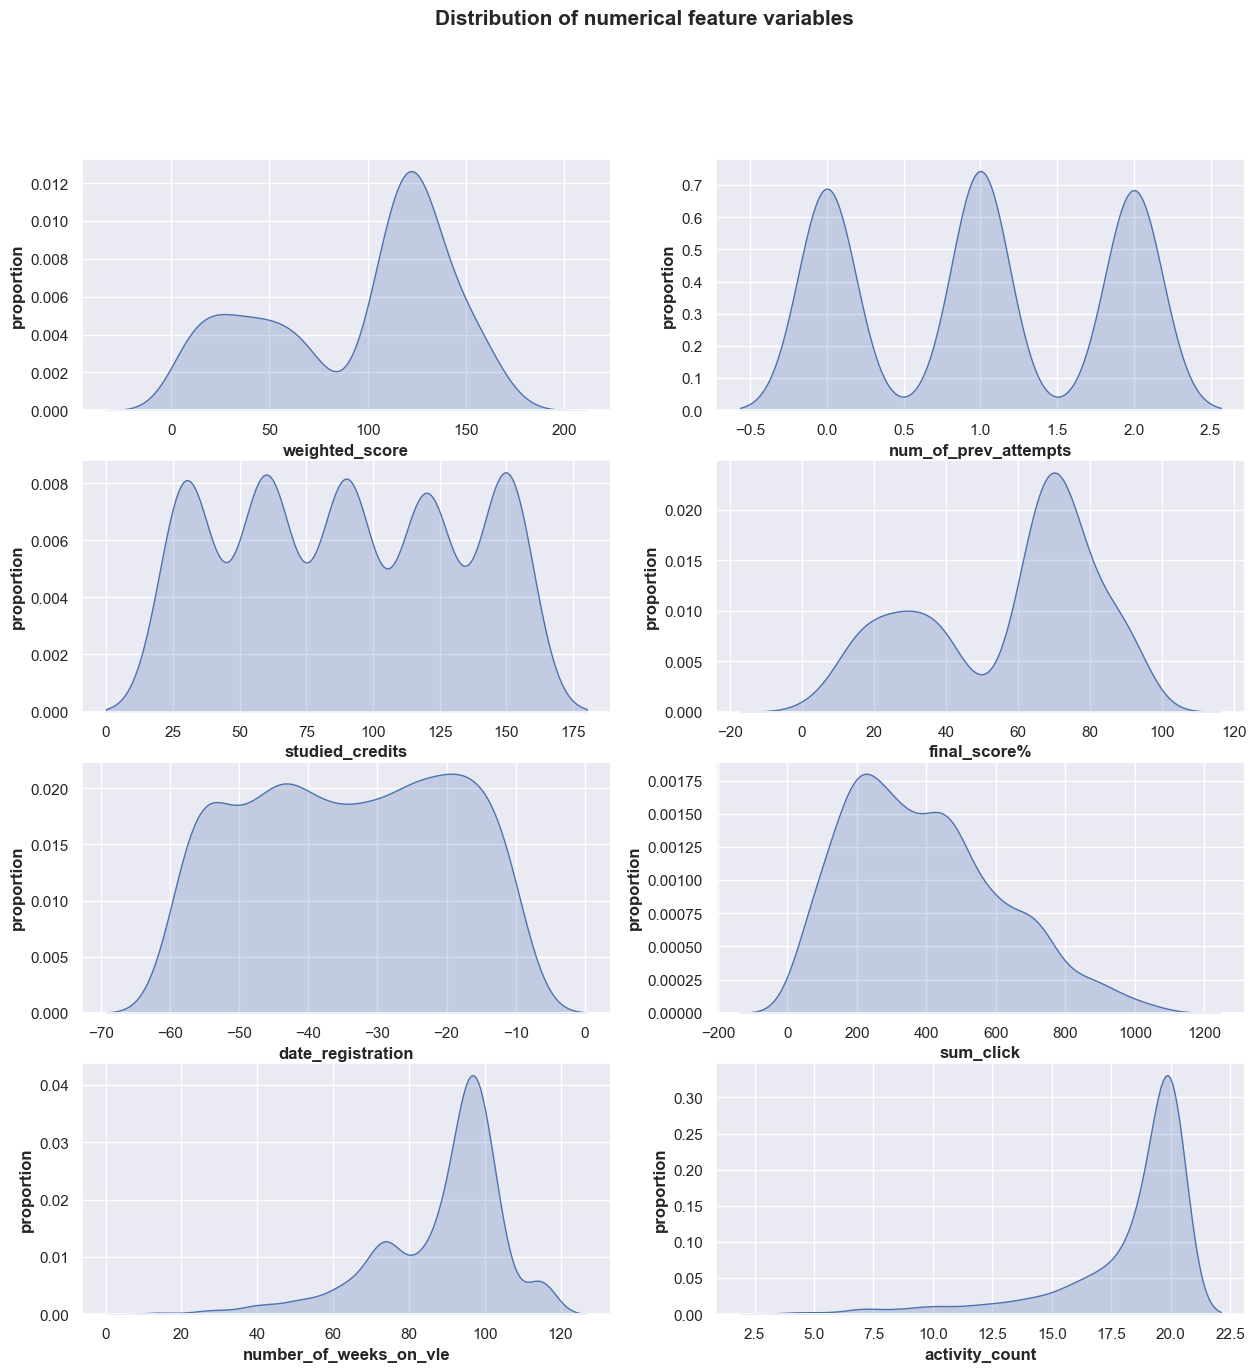

In [64]:
features_array = np.array(df_numerical.columns, dtype='object').reshape(4,2)
fig, ax  =  plt.subplots(4,2,sharey=False,figsize=(15,15))
for i, col in np.ndenumerate(features_array):
    sns.kdeplot(x =col, data = df_numerical, fill=True, ax = ax[i[0],i[1]])
    ax[i[0],i[1]].set_xlabel(col, fontweight="bold")
    ax[i[0],i[1]].set_ylabel("proportion", fontweight="bold")
plt.suptitle("Distribution of numerical feature variables", fontweight="bold", size=(15))
plt.show()

1. **Weighted Score**:
   - The positive skew means there’s a group of high-achieving students pulling the upper end of the distribution, while the majority cluster around moderate or lower scores.

2. **Number of Previous Attempts**:
   - A symmetric distribution here suggests that most students follow a predictable pattern, with few outliers attempting the course repeatedly.

3. **Studied Credits**:
   - The symmetry indicates a consistent approach in credit selection, with the majority sticking to the **90-120 credits** range, while only a few take on exceptionally high or low credit loads.

4. **Final Score (%)**:
   - A negative skew here emphasizes a majority of students performing above the average, though a small group with very low scores impacts the overall distribution negatively.

5. **Date of Registration**:
   - Since it is not numeric, this variable might serve as a categorical marker to analyze enrollment trends over time rather than contributing directly to numerical analyses.

6. **Total Clicks (Engagement in VLE)**:
   - The positive skew reflects that while a handful of students are highly engaged (with significant clicks), the majority remain less active on the platform.

7. **Number of Weeks on VLE**:
   - A slight negative skew suggests students tend to stay active for longer periods, although a minority drops out early, affecting the lower range.

8. **Activity Count**:
   - The negative skew indicates most students exhibit high activity levels, with fewer participants showing minimal engagement.

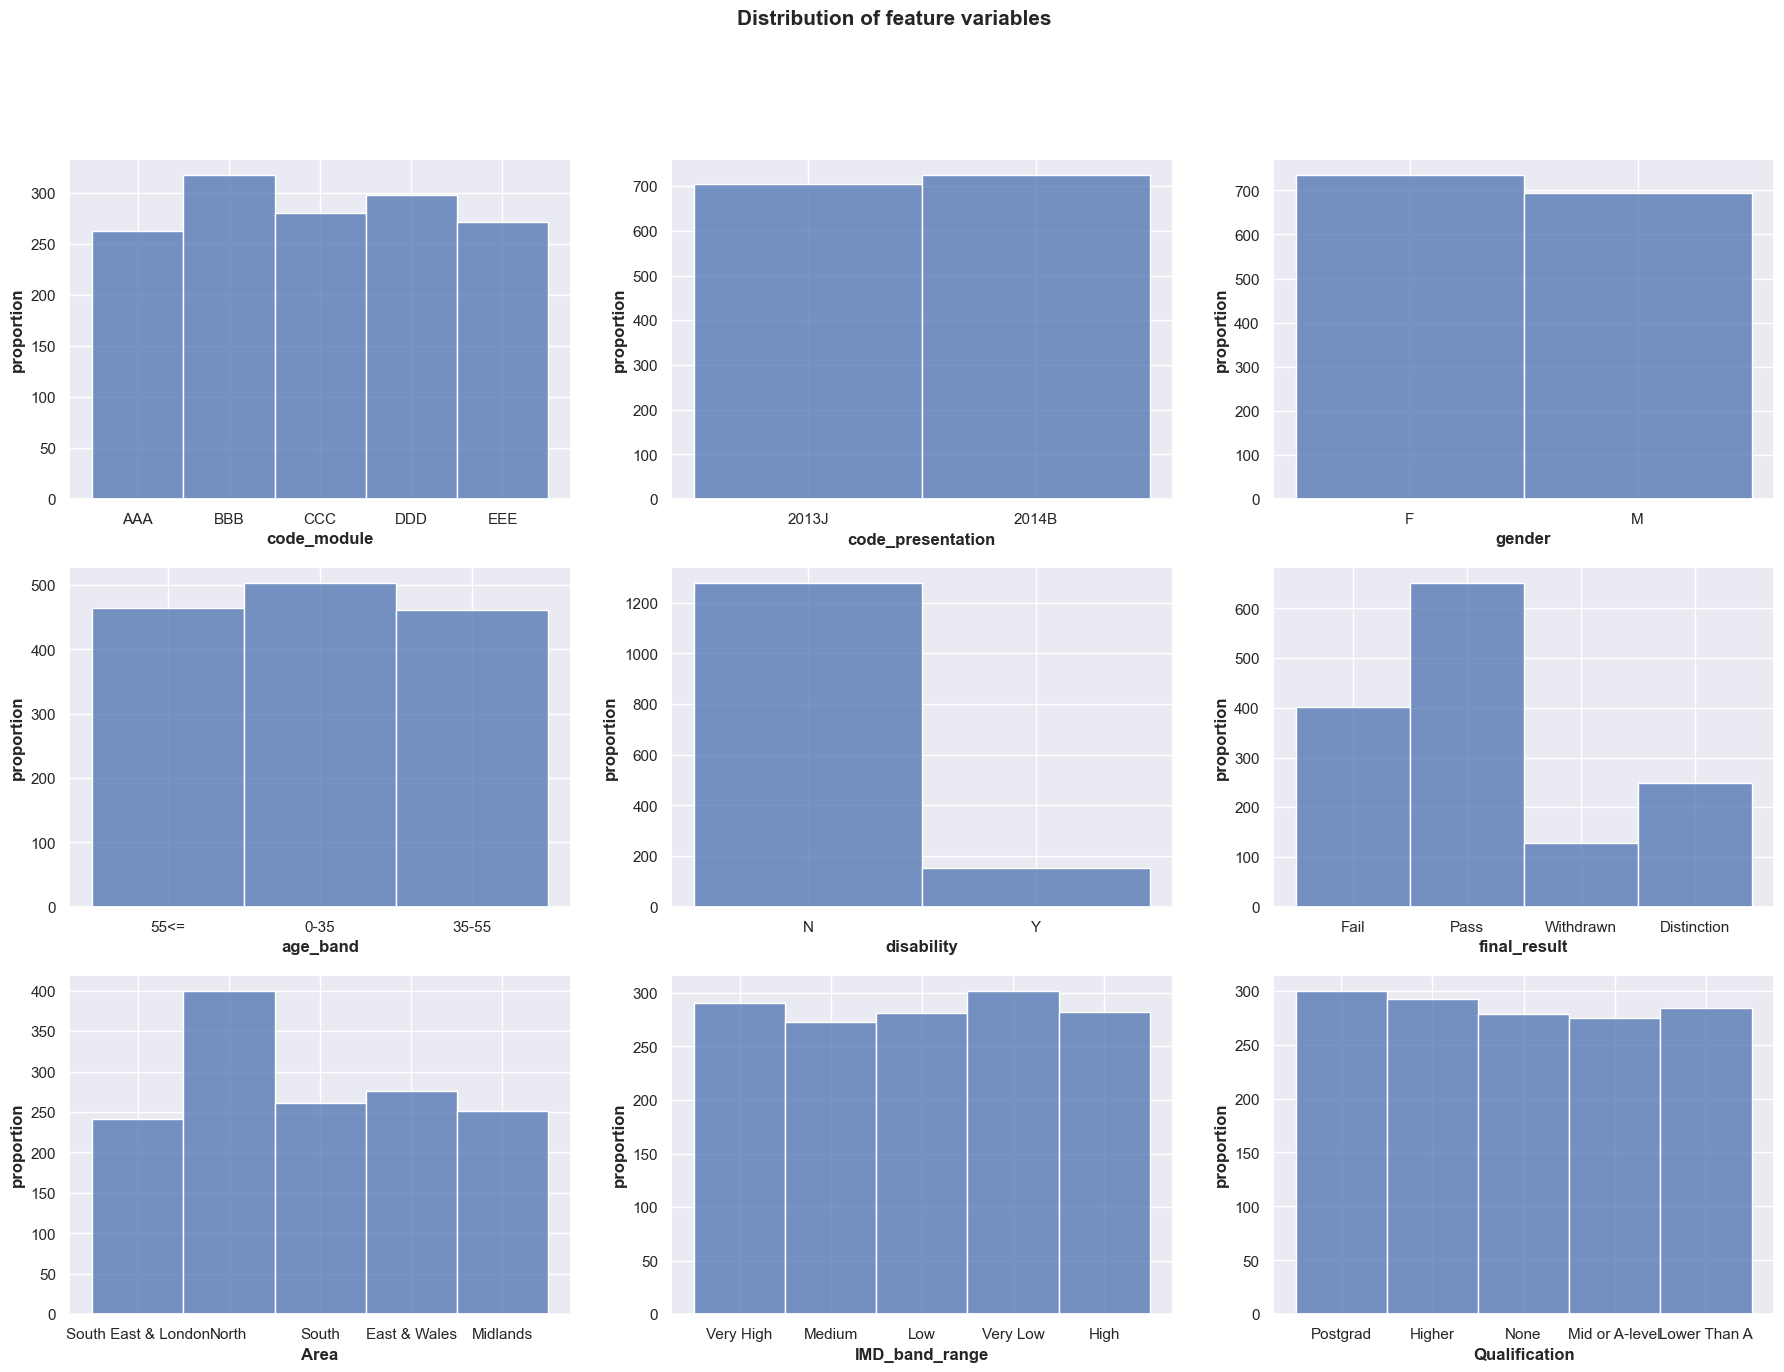

In [65]:
features_array_cat = np.array(df_categorical.columns, dtype='object').reshape(3,3)
fig, ax  =  plt.subplots(3,3,sharey=False,figsize=(22,15))
for i, col in np.ndenumerate(features_array_cat):
    sns.histplot(x =col, data = df_categorical, fill=True, ax = ax[i[0],i[1]])
    ax[i[0],i[1]].set_xlabel(col, fontweight="bold")
    ax[i[0],i[1]].set_ylabel("proportion", fontweight="bold")
plt.suptitle("Distribution of feature variables", fontweight="bold", size=(15))
plt.show()
#v

1. **Module Codes**:
   - A symmetrical distribution suggests a balanced course enrollment, though the higher numbers in the **BBB module** could indicate its popularity or importance within the curriculum.

2. **Presentation Code**:
   - A slight preference for **2013J** over **2014B** may reflect trends in course offerings or differences in student choices for specific academic terms.

3. **Gender**:
   - The near-equal split between male and female students, with a slight majority of females, indicates a diverse and balanced demographic.

4. **Age Bands**:
   - Most students fall into the **0–35 age band**, which aligns with typical enrollment trends in higher education. The almost equal distribution suggests inclusivity across age groups.

5. **Disability**:
   - The observation that fewer students are disabled highlights the need for continued efforts in accessibility and support for disabled individuals pursuing education.

6. **Final Results**:
   - The distribution underscores a majority of students passing, with fewer achieving distinctions. The number of failures and withdrawals emphasizes areas where interventions could improve success rates.

7. **Area**:
   - Concentration in the **north** suggests regional preferences or accessibility. The smaller numbers in **South East and London** may indicate either geographical or economic barriers.

8. **IMD Band Range**:
   - The representation across IMD bands, with most students in the **very low range**, suggests efforts to reach underprivileged areas are paying off. The fewer students in the medium range reflect potential gaps in socioeconomic diversity.

9. **Qualifications**:
   - The diversity in educational backgrounds indicates that the institution attracts a wide range of learners, fostering inclusivity and adaptability in its programs.

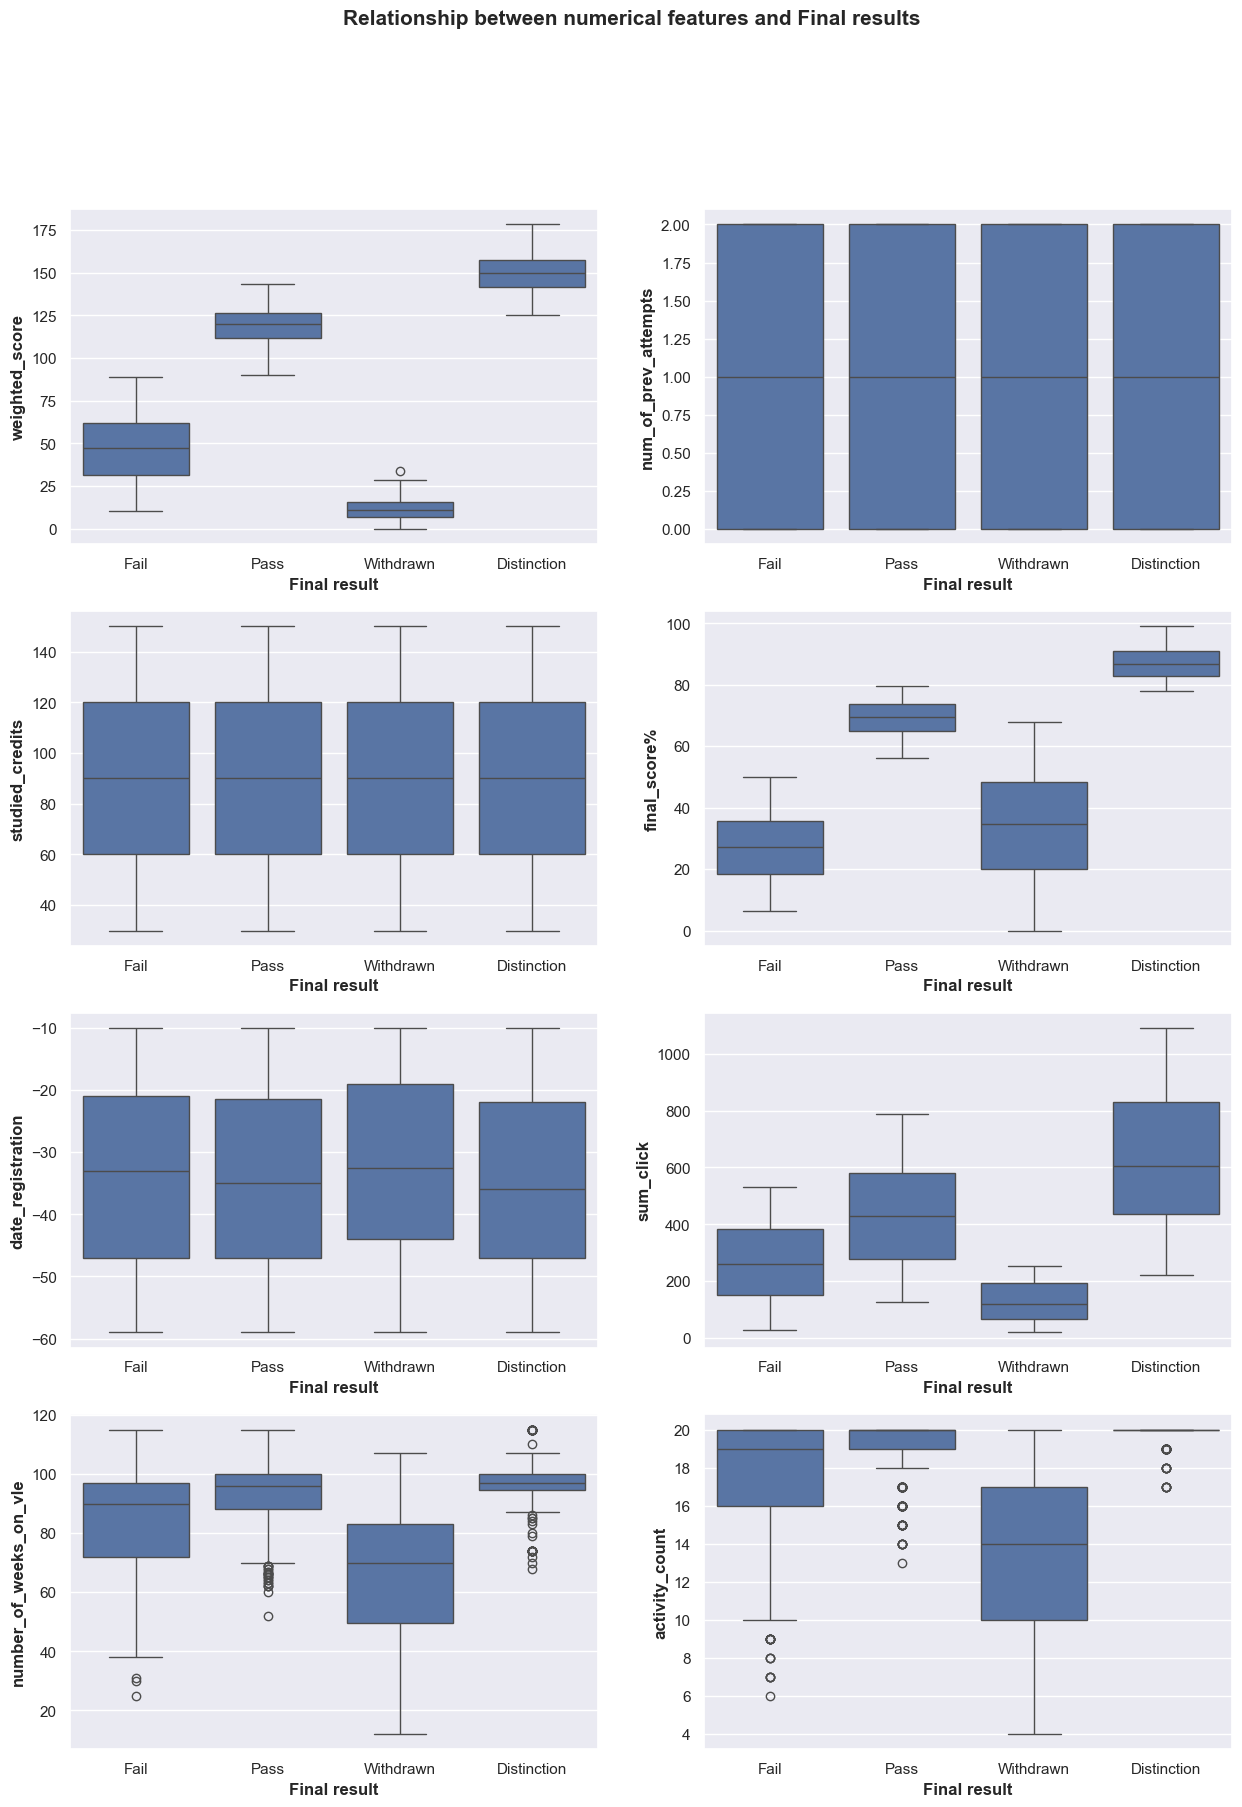

In [66]:
fig, ax  =  plt.subplots(4,2,sharey=False,figsize=(15,20 ))
for i, col in np.ndenumerate(features_array):
    sns.boxplot(ax = ax[i[0],i[1]], x = 'final_result', y = col , data = df_1)
    ax[i[0],i[1]].set_xlabel('Final result', fontweight="bold")
    #ax[i[0],i[1]].set_xticklabels(['benign','malignant'],fontweight="bold")
    ax[i[0],i[1]].set_ylabel(col, fontweight="bold")
    
plt.suptitle("Relationship between numerical features and Final results", fontweight="bold", size=(15))
plt.show()

1. **Weighted Score**:
   - A strong positive correlation exists between the weighted score and final results. Lower scores are associated with failing or withdrawal, while higher scores correspond to passing and distinctions.

2. **Number of Previous Attempts**:
   - No significant relationship is found between the number of attempts and the final result, suggesting retries don't directly impact outcomes.

3. **Studied Credits**:
   - There is no apparent correlation between the number of credits studied and the final results, indicating that credit load does not influence success or failure.

4. **Final Score (%)**:
   - This metric shows a strong positive correlation with final results. Lower percentages align with failing or withdrawal, whereas higher percentages correspond to passing and distinctions.

5. **Date of Registration**:
   - No relationship is observed between registration dates and final results, suggesting enrollment timing does not affect outcomes.

6. **Total Clicks (Engagement in VLE)**:
   - A strong positive relationship exists between engagement (clicks) and final results. Students with fewer clicks are more likely to fail or withdraw, while those with higher engagement tend to pass and achieve distinctions.

7. **Number of Weeks on VLE**:
   - A weak relationship is identified, with students who spend fewer weeks on the VLE being more likely to fail or withdraw. However, some long-term users also fail, showing exceptions.

8. **Activity Count**:
   - There is a positive relationship between activity levels and final results. High activity aligns with distinctions and passing, while low activity correlates with failing or withdrawal.


## **3. Categoriacal Features Engineering**

In this section, we will focus on encoding our categorical variables to enhance the efficiency and accuracy of our data analysis and modeling process. Transforming these variables into numerical representations will enable us to better evaluate the relationships between feature variables and the target, while effectively addressing multicollinearity issues. Additionally, this step is critical for improving the overall performance of the model, as encoding is a well-established best practice in data preprocessing.

To ensure the most appropriate encoding techniques are applied:
- **Ordinal Encoder** will be used for our target variable, as it is ordinal in nature, preserving the inherent order of the categories.
- **Label Encoder** will be applied to the feature variables, converting them into numeric labels that are simple for the model to interpret.

By implementing these encoding methods, we lay the groundwork for accurate insights, streamlined analysis, and robust predictive performance.

In [67]:
df_1.drop(['date_registration'],axis=1,inplace=True)
#df_categorical.drop(['code_module','code_presentation'],axis=1,inplace=True)

In [68]:
categories = [['Withdrawn', 'Fail', 'Pass', 'Distinction']]

oe = OrdinalEncoder(categories=categories, handle_unknown='use_encoded_value', unknown_value=-1)
encoded_df = df_1.copy()
print(df_1['final_result'].unique())
encoded_df['final_result'] = oe.fit_transform(df_1[['final_result']])
encoded_df['final_result'] = encoded_df['final_result'].fillna(-1).astype(int)


['Fail' 'Pass' 'Withdrawn' 'Distinction']


In [69]:
encoded_df.head(10)

,code_module,code_presentation,weighted_score,gender,age_band,num_of_prev_attempts,studied_credits,disability,final_result,final_score%,sum_click,number_of_weeks_on_vle,activity_count,Area,IMD_band_range,Qualification
0,AAA,2013J,63.4,F,55<=,1,30,N,1,39.625,148,72,14,South East & London,Very High,Postgrad
1,AAA,2013J,92.8,F,0-35,0,90,N,2,58.000,448,97,20,North,Medium,Higher
2,AAA,2013J,121.2,M,55<=,1,90,N,2,75.750,335,97,20,South,Low,Postgrad
3,AAA,2013J,77.6,F,0-35,0,90,N,1,48.500,108,84,18,East & Wales,Very Low,Higher
4,AAA,2013J,33.4,F,55<=,0,120,N,1,20.875,417,97,20,Midlands,Very High,None
5,AAA,2013J,62.4,F,35-55,2,120,N,1,39.000,191,79,17,South East & London,High,Postgrad
6,AAA,2013J,21.6,M,55<=,1,60,N,0,54.000,149,66,14,East & Wales,Very High,Mid or A-level
7,AAA,2013J,126.2,F,0-35,1,150,N,2,78.875,521,97,20,South East & London,Very Low,Postgrad
8,AAA,2013J,139.6,F,0-35,1,120,N,3,87.250,368,97,20,North,Medium,Lower Than A
9,AAA,2013J,107.6,F,35-55,2,30,N,2,67.250,585,97,20,North,High,Higher


In [70]:
label_encoder = LabelEncoder()

cat_columns = list(df_categorical.columns)
cat_columns.remove('final_result')
for col in df_categorical.columns:
    encoded_df[col] = label_encoder.fit_transform(encoded_df[col])

encoded_df.head(15)

,code_module,code_presentation,weighted_score,gender,age_band,num_of_prev_attempts,studied_credits,disability,final_result,final_score%,sum_click,number_of_weeks_on_vle,activity_count,Area,IMD_band_range,Qualification
0,0,0,63.4,0,2,1,30,0,1,39.625,148,72,14,4,3,4
1,0,0,92.8,0,0,0,90,0,2,58.000,448,97,20,2,2,0
2,0,0,121.2,1,2,1,90,0,2,75.750,335,97,20,3,1,4
3,0,0,77.6,0,0,0,90,0,1,48.500,108,84,18,0,4,0
4,0,0,33.4,0,2,0,120,0,1,20.875,417,97,20,1,3,3
5,0,0,62.4,0,1,2,120,0,1,39.000,191,79,17,4,0,4
6,0,0,21.6,1,2,1,60,0,0,54.000,149,66,14,0,3,2
7,0,0,126.2,0,0,1,150,0,2,78.875,521,97,20,4,4,4
8,0,0,139.6,0,0,1,120,0,3,87.250,368,97,20,2,2,1
9,0,0,107.6,0,1,2,30,0,2,67.250,585,97,20,2,0,0


## **4 Correlation and Feature Selection**

Since the majority of our variables, including the target variable, are categorical, we will utilize Spearman rank correlation to assess the relationships within our dataset. Spearman correlation is ideal for this context, as it measures the strength and direction of monotonic relationships between two variables. By focusing on rankings rather than raw values, this method is robust to outliers and does not require the assumption of linearity.

Using Spearman rank correlation will allow us to uncover subtle relationships between the feature variables and the target variable. This technique is particularly valuable for understanding associations within ordinal or categorical data, and it enables us to identify patterns that might otherwise remain hidden. Additionally, Spearman correlation supports feature selection by highlighting the most relevant predictors for our model, while helping to address multicollinearity concerns.

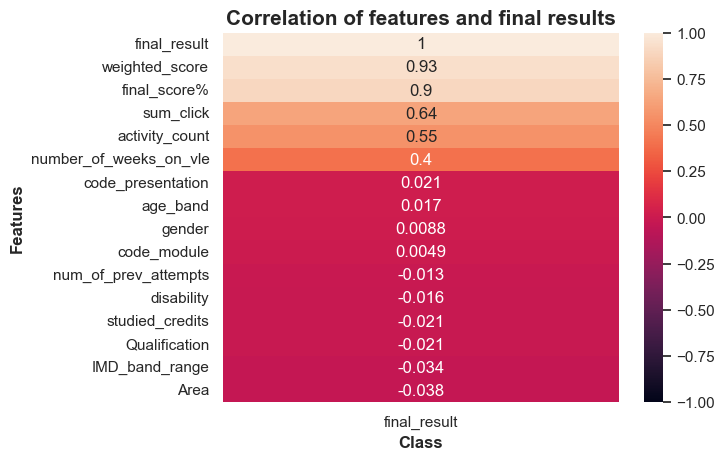

In [71]:
sns.heatmap(
    encoded_df.corr(method='spearman')[['final_result']]\
    .sort_values(
        by = 'final_result',
        ascending=False
    ),
    vmin=-1,
    vmax=1,
    annot=True
)
plt.title('Correlation of features and final results', fontweight = 'bold',size=(15))
plt.xlabel('Class', fontweight = 'bold')
plt.ylabel('Features',fontweight= 'bold')
plt.show()


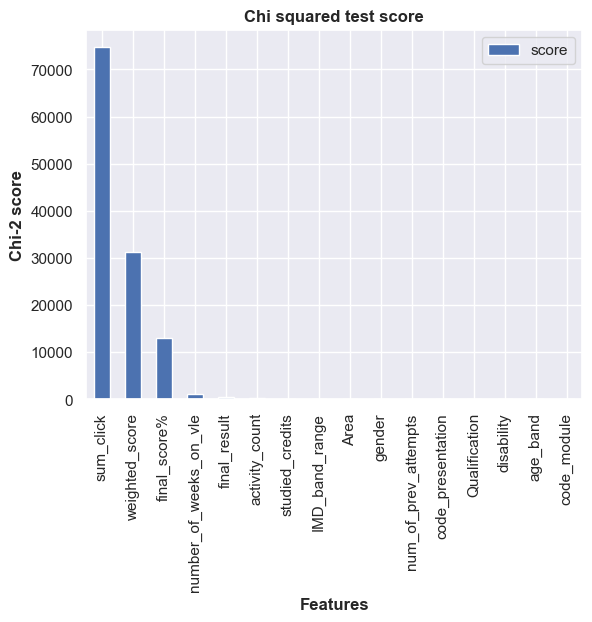

In [72]:
scores = chi2(encoded_df,encoded_df['final_result'])
chi_vals = pd.DataFrame(scores[0],index = encoded_df.columns,columns = ['score'])
chi_vals.sort_values(ascending=False,inplace=True,by='score')
chi_vals.plot.bar()
plt.xlabel('Features',fontweight="bold")
plt.ylabel('Chi-2 score',fontweight="bold")
plt.title('Chi squared test score',fontweight="bold")
plt.show()

In [73]:
final_columns = list(df_vif['FEATURES'])

NameError: name 'df_vif' is not defined

In [ ]:
encoded_df[final_columns]

,Area,weighted_score,activity_count,sum_click,final_score%,number_of_weeks_on_vle,studied_credits,IMD_band_range,Qualification,code_module,num_of_prev_attempts,age_band,code_presentation,gender,disability
0,4,63.4,14,148,39.625,72,30,3,4,0,1,2,0,0,0
1,2,92.8,20,448,58.000,97,90,2,0,0,0,0,0,0,0
2,3,121.2,20,335,75.750,97,90,1,4,0,1,2,0,1,0
3,0,77.6,18,108,48.500,84,90,4,0,0,0,0,0,0,0
4,1,33.4,20,417,20.875,97,120,3,3,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1424,4,40.8,19,232,25.500,88,30,0,3,4,0,1,1,1,0
1425,0,145.4,20,1033,90.875,97,90,3,1,4,0,1,1,1,0
1426,0,141.0,20,748,88.125,97,90,1,2,4,2,2,1,0,0
1427,1,24.8,12,126,15.500,61,30,3,1,4,1,1,1,0,1


## **Modelling**



 Given the complexity of student performance data—comprising **demographics, engagement metrics, and academic history**—a robust and efficient machine learning model is essential.  

I propose using an **XGBoost Multiclass Classifier** due to its **high accuracy, scalability, and ability to handle complex relationships in data**. Below are key reasons why XGBoost is the best choice:  

1. **Handles Non-Linearity & Interactions**  
   - Student performance is influenced by multiple interacting factors (e.g., study habits, prior attempts, engagement levels).  
   - XGBoost captures these relationships more effectively than traditional models.  

2. **Efficient Handling of Missing Data**  
   - Student datasets often have missing values (e.g., incomplete engagement logs).  
   - XGBoost naturally learns how to handle missing data, reducing the need for imputation.  

3. **Feature Importance & Interpretability**  
   - XGBoost provides feature importance scores, helping educators understand **which factors contribute most to student success or failure**.  
   - Insights from feature importance can guide **personalized interventions**.  

4. **Optimized for Performance**  
   - XGBoost uses **gradient boosting**, an ensemble method that outperforms traditional classification models.  
   - It is computationally efficient, making it suitable for large datasets.  

5. **Multiclass Prediction Capability**  
   - Student outcomes often fall into categories such as **Pass, Fail, Distinction, and Withdrawn**.  
   - XGBoost supports **multi-class classification**, making it an ideal choice for predicting final results.  

In [ ]:
X = encoded_df[final_columns]
y = encoded_df['final_result']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.head()

,Area,weighted_score,activity_count,sum_click,final_score%,number_of_weeks_on_vle,studied_credits,IMD_band_range,Qualification,code_module,num_of_prev_attempts,age_band,code_presentation,gender,disability
306,1,52.6,18,223,29.222222,92,30,4,4,1,0,2,0,1,0
1139,4,48.1,20,487,28.294118,93,60,1,4,3,2,1,1,0,0
31,3,115.0,20,662,71.875000,97,120,3,4,0,0,0,0,1,0
210,3,28.0,20,442,16.470588,100,150,2,4,0,0,2,1,0,0
924,4,119.5,19,301,66.388889,111,90,3,3,3,1,0,0,1,0


In [ ]:
X_test.head()

,Area,weighted_score,activity_count,sum_click,final_score%,number_of_weeks_on_vle,studied_credits,IMD_band_range,Qualification,code_module,num_of_prev_attempts,age_band,code_presentation,gender,disability
123,0,127.4,20,421,79.625000,97,150,2,3,0,2,2,0,0,0
1189,2,143.4,20,600,79.666667,102,150,4,2,4,0,1,0,1,0
462,0,37.9,19,387,21.055556,93,90,2,0,1,1,2,1,0,0
351,4,39.1,17,224,21.722222,85,90,2,0,1,1,1,0,1,0
1009,0,61.8,18,265,36.352941,83,60,1,2,3,1,0,1,0,0


In [ ]:
xgb_model = xgb.XGBClassifier(n_estimators=2, objective='multi:softmax', num_class=4)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)

In [ ]:
y_pred = xgb_model.predict(X_train)

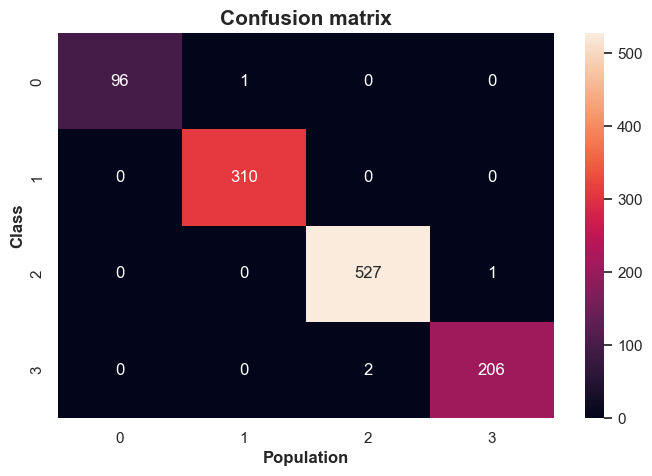

In [ ]:
cm = confusion_matrix(y_train, y_pred)

fig, ax = plt.subplots(figsize=(8,5)) 
ax = sns.heatmap(cm,fmt='g',annot=True)
ax.set_title("Confusion matrix", fontweight = 'bold',size=(15))
ax.set_xlabel('Population', fontweight="bold")
#ax.set_xticklabels(['benign','malignant'])
ax.set_ylabel('Class', fontweight="bold")
#ax.set_yticklabels(['benign','malignant'])
plt.show()

In [ ]:
train_accuracy = accuracy_score(y_train, y_pred)
train_accuracy

0.9965004374453194

In [ ]:
y_hat_pred = xgb_model.predict(X_test)

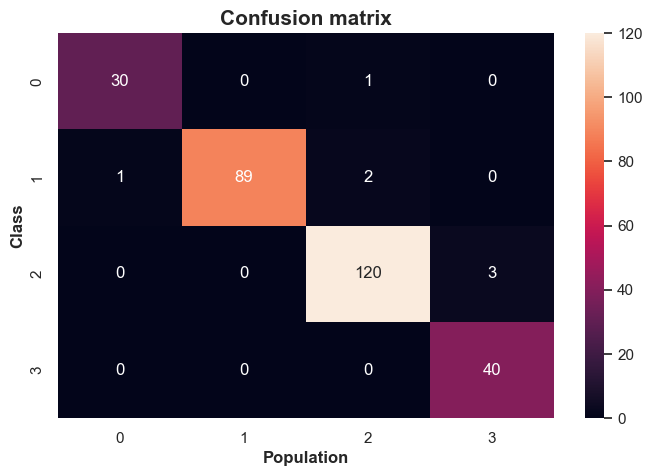

In [ ]:
cm = confusion_matrix(y_test, y_hat_pred)

fig, ax = plt.subplots(figsize=(8,5)) 
ax = sns.heatmap(cm,fmt='g',annot=True)
ax.set_title("Confusion matrix", fontweight = 'bold',size=(15))
ax.set_xlabel('Population', fontweight="bold")
#ax.set_xticklabels(['benign','malignant'])
ax.set_ylabel('Class', fontweight="bold")
#ax.set_yticklabels(['benign','malignant'])
plt.show()

In [ ]:
train_accuracy = accuracy_score(y_test, y_hat_pred)
train_accuracy

0.9755244755244755